In [53]:
import argparse
import cv2
import FrEIA.framework as Ff
import FrEIA.modules as Fm
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

from my_models.style_gan_2 import Generator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torchvision.utils import make_grid

# Select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)

In [94]:
g = Generator(1024, 512, 8, pretrained=True).eval().to(device)
g.noises = [n.to(device) for n in g.noises]


def generate_image(g, latent_vector):
    with torch.no_grad():
        img, _ = g([latent_vector], input_is_latent=True, noise=g.noises)
        img = make_grid(img.cpu(), normalize=True, range=(-1, 1))
    img = transforms.ToPILImage('RGB')(img)
    img.resize((256, 256))
    return img


def display_landmarks(lm, img_size=256):
    img = np.zeros((img_size, img_size, 3), np.uint8)
    
    if lm.max() <= 1.0:
        lm = (lm + 1.) * 127.5
        
    if torch.is_tensor(lm):
        lm = lm.numpy()
        
    for (x, y) in lm:
        cv2.circle(img, (x, y), 0, (255, 255, 255), 2)
    return img
    

def move_and_show_landmarks(inn, landmarks, coeffs, emotion):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 4), dpi=80)
    fig.suptitle(emotion)
    for i, coeff in enumerate(coeffs):
        new_lm = landmarks.clone()
        inn.eval()
        direction = inn.inverse(coeff).view(-1, 2)
        new_lm[17:] += direction
        print(torch.sigmoid(inn(new_lm[17:].view(1, -1).to(device))))
        img = display_landmarks(new_lm.numpy(), 256)
        ax[i].imshow(img)
        ax[i].set_title('Coeff: %f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()


def move_and_show_latents(g, inn, latent_vector, coeffs, emotion):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 4), dpi=80)
    fig.suptitle(emotion)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.clone()
        inn.eval()
        direction = inn.inverse(coeff).view(18, 512)
        new_latent_vector[:8] = (new_latent_vector + direction)[:8]
        new_latent_vector = new_latent_vector.unsqueeze(0).to(device)
        print(torch.sigmoid(inn(new_latent_vector.view(1, -1))))
        img = generate_image(g, new_latent_vector)
        ax[i].imshow(img)
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()
    
    
def move_and_show_latents_linear(g, latent_vector, direction, coeffs, emotion):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 4), dpi=80)
    fig.suptitle(emotion)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.clone()
        new_latent_vector[:8] = (latent_vector + coeff * direction)[:8]
        new_latent_vector = new_latent_vector.unsqueeze(0).to(device)
        print(torch.sigmoid(inn(new_latent_vector.view(1, -1))))
        img = generate_image(g, new_latent_vector)
        ax[i].imshow(img)
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [3]:
# Load data
data = torch.load('/home/meissen/Datasets/RAVDESS/Aligned256/latent_data.pt')

# Select data
target_emotion = 'sad'

mapping = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgust': 6,
    'surprised': 7
}

shuffle_inds = torch.randperm(data['landmarks'].shape[0])

# """

# Landmarks for original labels
emotions = data['emotions'][shuffle_inds]
landmarks = data['landmarks'][shuffle_inds]
# Get data which corresponds to emotion and other data which doesn't
target_emo_inds = (emotions == mapping[target_emotion]).nonzero()
other_emo_inds = (emotions != mapping[target_emotion]).nonzero()[:len(target_emo_inds)]
X = torch.cat((landmarks[target_emo_inds][:, 0], landmarks[other_emo_inds][:, 0]), dim=0)
y = torch.cat((torch.ones(len(target_emo_inds), 1), torch.zeros(len(target_emo_inds), 1)), dim=0)
# Shuffle again
shuffle_inds2 = torch.randperm(X.shape[0])
X = X[shuffle_inds2]
y = y[shuffle_inds2]
# Center landmarks
X = (X / 127.5) - 1
# Delete unused data
del emotions, landmarks

"""

# Latents for original labels
emotions = data['emotions'][shuffle_inds]
latents = data['latents'][shuffle_inds]
# Get data which corresponds to emotion and other data which doesn't
target_emo_inds = (emotions == mapping[target_emotion]).nonzero()
other_emo_inds = (emotions != mapping[target_emotion]).nonzero()[:len(target_emo_inds)]
X = torch.cat((latents[target_emo_inds][:, 0], latents[other_emo_inds][:, 0]), dim=0)
y = torch.cat((torch.ones(len(target_emo_inds), 1), torch.zeros(len(target_emo_inds), 1)), dim=0)
# Shuffle again
shuffle_inds2 = torch.randperm(X.shape[0])
X = X[shuffle_inds2]
y = y[shuffle_inds2]
# Delete unused data
del emotions, latents

"""

# Delete data to save memory
del data

print(X.shape, y.shape)

torch.Size([42374, 68, 2]) torch.Size([42374, 1])


# Non Linear

In [21]:
class InvModel(nn.Module):
    def __init__(self, model):
        super(InvModel, self).__init__()

        self.inn = model.inn
        self.linear = model.linear

    def forward(self, x):
        x = x.view((x.size(0), -1))
        x = self.inn(x)
        x = self.linear(x)
        return x

    def inverse(self, coeff):
        zero = self.inn(torch.zeros_like(self.linear.weight), rev=True).detach().cpu()
        direction = self.linear.weight * coeff
        direction = self.inn(direction, rev=True).detach().cpu()
        return direction - zero


class PLNonLinClassification(pl.LightningModule):
    def __init__(self, X, y, split=(0.8, 0.1, 0.1)):
        super(PLNonLinClassification, self).__init__()
        
        input_dim = 1
        for v in X.shape[1:]:
            input_dim *= v

        self.X = X
        self.y = y
        assert sum(split) == 1.0
        self.split = split
        self.train_start = 0
        self.val_start = int(len(X) * split[0])
        self.test_start = self.val_start + int(len(X) * split[1])

        def subnet_fc(c_in, c_out):
            return nn.Sequential(
                nn.Linear(c_in, c_out),
                nn.BatchNorm1d(c_out),
                nn.ReLU(),
                # nn.Linear(input_dim, c_out),
                # nn.BatchNorm1d(input_dim),
                # nn.ReLU()
            )

        nodes = [Ff.InputNode(input_dim, name='input')]

        nodes.append(Ff.Node(nodes[-1],
                             Fm.GLOWCouplingBlock,
                             {'subnet_constructor': subnet_fc, 'clamp': 2.0},
                             name='coupling_1'))

        nodes.append(Ff.OutputNode(nodes[-1], name='output'))
        self.inn = Ff.ReversibleGraphNet(nodes, verbose=False)

        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.view((x.size(0), -1))
        z = self.inn(x)
        x = self.linear(z)
        return x

    def inverse(self, coeff):
        direction = self.linear.weight * coeff
        direction = self.inn(direction, rev=True).detach().cpu()
        return direction

    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.view(-1, 1))
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.view(-1, 1))
        return {'val_loss': loss}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
        return torch.optim.Adam(self.parameters(), lr=0.002)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        X = self.X[:self.val_start]
        y = self.y[:self.val_start]
        ds = torch.utils.data.TensorDataset(X, y)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        X = self.X[self.val_start:self.test_start]
        y = self.y[self.val_start:self.test_start]
        ds = torch.utils.data.TensorDataset(X, y)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    
    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        X = self.X[self.test_start:]
        y = self.y[self.test_start:]
        ds = torch.utils.data.TensorDataset(X, y)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl


def r1_loss(pred, inp):
    grad, = torch.autograd.grad(
        outputs=pred.sum(), inputs=inp, create_graph=True
    )
    grad_penalty = grad.pow(2).view(grad.shape[0], -1).sum(1).mean()

    return grad_penalty


# Train
# model = PLNonLinClassification(X[:, 17:], y)  # Don't use chin
model = PLNonLinClassification(X, y)
trainer = pl.Trainer(
    gpus=1,
    logger=False,
    show_progress_bar=True,
    min_epochs=5
)
trainer.fit(model)
inn = InvModel(model)
model = model.cpu()

# Evaluate
# X_train = X[:model.val_start, 17:]
X_train = X[:model.val_start]
y_train = y[:model.val_start]
# X_test = X[model.test_start:, 17:]
X_test = X[model.test_start:]
y_test = y[model.test_start:]
with torch.no_grad():
    # Train set
    y_pred = torch.sigmoid(inn(X_train.to(device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Train Accuracy {accuracy_score(y_train.numpy(), y_pred):.4f}")
    
    # Test set
    y_pred = torch.sigmoid(inn(X_test.to(device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Test Accuracy {accuracy_score(y_test.numpy(), y_pred):.4f}")

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                      Name                Type Params
0                      inn  ReversibleGraphNet   84 M
1          inn.module_list          ModuleList   84 M
2        inn.module_list.1   GLOWCouplingBlock   84 M
3     inn.module_list.1.s1          Sequential   42 M
4   inn.module_list.1.s1.0              Linear   42 M
5   inn.module_list.1.s1.1         BatchNorm1d   18 K
6   inn.module_list.1.s1.2                ReLU    0  
7     inn.module_list.1.s2          Sequential   42 M
8   inn.module_list.1.s2.0              Linear   42 M
9   inn.module_list.1.s2.1         BatchNorm1d   18 K
10  inn.module_list.1.s2.2                ReLU    0  
11       inn.module_list.2               dummy    0  
12                  linear              Linear    9 K
                                                                 

Epoch 1:   0%|          | 2/1193 [00:00<00:40, 29.55batch/s, batch_idx=1, gpu=0, loss=16.600]

Epoch 5: 100%|██████████| 1193/1193 [00:26<00:00, 44.20batch/s, batch_idx=1059, gpu=0, loss=0.626]
Train Accuracy 0.9336
Test Accuracy 0.9339


tensor([[0.]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[9.5097e-07]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward>)


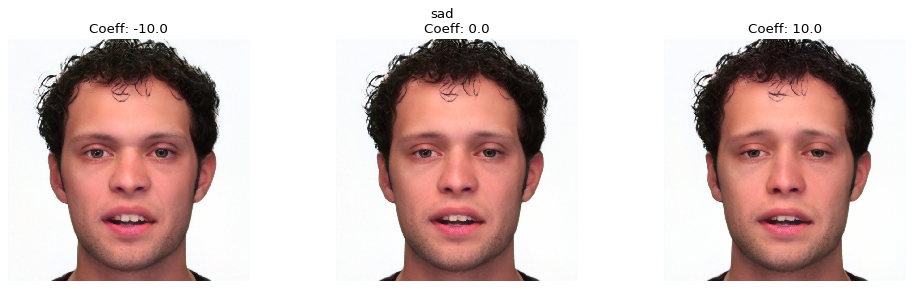

In [22]:
move_and_show_latents(g, inn, X[6], [-10., 0., 10.], target_emotion)

tensor([[3.5987e-08]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward>)


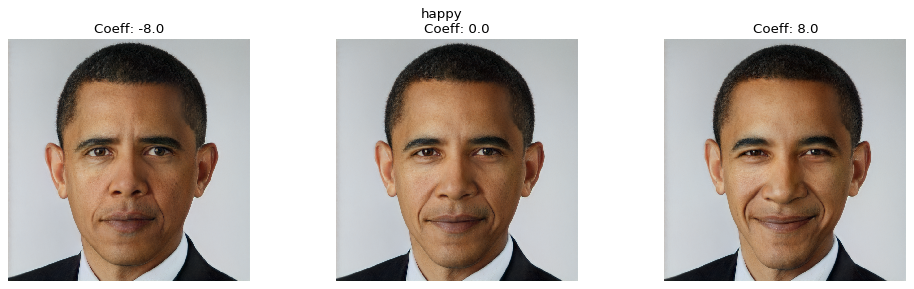

tensor([[4.0196e-16]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward>)


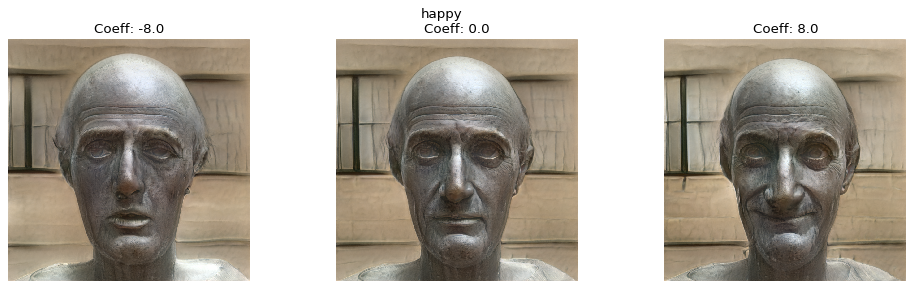

In [19]:
latent = torch.load('saves/projected_images/obama.pt')
move_and_show_latents(g, inn, latent, [-8, 0, 8], target_emotion)

latent = torch.load('saves/projected_images/TUM_guy.pt')
move_and_show_latents(g, inn, latent, [-8, 0, 8], target_emotion)

# Linear

In [238]:
%%time

# Train and val data preparation
split = 0.9
X_train = X[:int(len(X) * split)]
X_train = X_train.view(X_train.shape[0], -1).numpy()
y_train = y[:int(len(y) * split)].numpy()
y_train = y_train.reshape(y_train.shape[0],)
X_test = X[int(len(X) * split):]
X_test = X_test.view(X_test.shape[0], -1).numpy()
y_test = y[int(len(y) * split):].numpy()
y_test = y_test.reshape(y_test.shape[0],)

# Training
clf = LogisticRegression(class_weight='balanced', max_iter=1000).fit(X_train, y_train)

# Get direction
direction = torch.tensor(clf.coef_.reshape((18, 512)))

# Evaluate
y_pred = clf.predict(X_train)
print(f"Train Accuracy {accuracy_score(y_train, y_pred):.4f}")
y_pred = clf.predict(X_test)
print(f"Test Accuracy {accuracy_score(y_test, y_pred):.4f}")

/home/meissen/miniconda3/envs/emotion-aware-facial-animation/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Accuracy 0.9806
Test Accuracy 0.9729
CPU times: user 31min 21s, sys: 2min 19s, total: 33min 41s
Wall time: 4min 14s


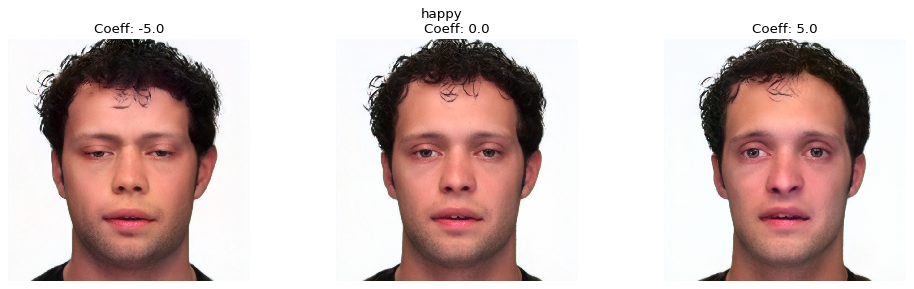

In [246]:
move_and_show_latents_linear(g, X[1], direction, [-5, 0, 5], target_emotion)

# Tests

In [27]:
class PLNonLinClassification(pl.LightningModule):
    def __init__(self, X, y, split=(0.8, 0.1, 0.1)):
        super(PLNonLinClassification, self).__init__()
        
        input_dim = 1
        for v in X.shape[1:]:
            input_dim *= v

        self.X = X
        self.y = y
        assert sum(split) == 1.0
        self.split = split
        self.train_start = 0
        self.val_start = int(len(X) * split[0])
        self.test_start = self.val_start + int(len(X) * split[1])

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, input_dim),
            # nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def inverse(self, coeff):
        direction = self.linear.weight * coeff
        direction = self.inn(direction, rev=True).detach().cpu()
        return direction

    def training_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.view(-1, 1))
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        # REQUIRED
        x, y = batch
        y_hat = self.forward(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.view(-1, 1))
        return {'val_loss': loss}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
        return torch.optim.Adam(self.parameters(), lr=0.002)

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        X = self.X[:self.val_start]
        y = self.y[:self.val_start]
        ds = torch.utils.data.TensorDataset(X, y)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        X = self.X[self.val_start:self.test_start]
        y = self.y[self.val_start:self.test_start]
        ds = torch.utils.data.TensorDataset(X, y)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl
    
    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        X = self.X[self.test_start:]
        y = self.y[self.test_start:]
        ds = torch.utils.data.TensorDataset(X, y)
        dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)
        return dl


# Train
model = PLNonLinClassification(X[:, 17:], y)  # Don't use chin
# model = PLNonLinClassification(X, y)
trainer = pl.Trainer(
    gpus=1,
    logger=False,
    show_progress_bar=True,
    min_epochs=5
)
trainer.fit(model)
inn = model.model

# Evaluate
X_train = X[:model.val_start, 17:]
# X_train = X[:model.val_start]
y_train = y[:model.val_start]
X_test = X[model.test_start:, 17:]
# X_test = X[model.test_start:]
y_test = y[model.test_start:]
with torch.no_grad():
    # Train set
    y_pred = torch.sigmoid(inn(X_train.to(device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Train Accuracy {accuracy_score(y_train.numpy(), y_pred):.4f}")
    
    # Test set
    y_pred = torch.sigmoid(inn(X_test.to(device))).cpu().numpy().reshape(-1,)
    y_pred = np.round(y_pred)
    print(f"Test Accuracy {accuracy_score(y_test.numpy(), y_pred):.4f}")

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
      Name        Type Params
0    model  Sequential   10 K
1  model.0     Flatten    0  
2  model.1      Linear   10 K
3  model.2        ReLU    0  
4  model.3      Linear  103  
                                                                 

Epoch 1:   9%|▊         | 104/1193 [00:00<00:01, 590.78batch/s, batch_idx=103, gpu=0, loss=0.693]

Epoch 5: 100%|██████████| 1193/1193 [00:01<00:00, 655.44batch/s, batch_idx=1059, gpu=0, loss=0.557]
Train Accuracy 0.6836
Test Accuracy 0.6885


/home/meissen/miniconda3/envs/emotion-aware-facial-animation/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  del sys.path[0]


tensor([[0.0375]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5000]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.8000]], device='cuda:0', grad_fn=<SigmoidBackward>)


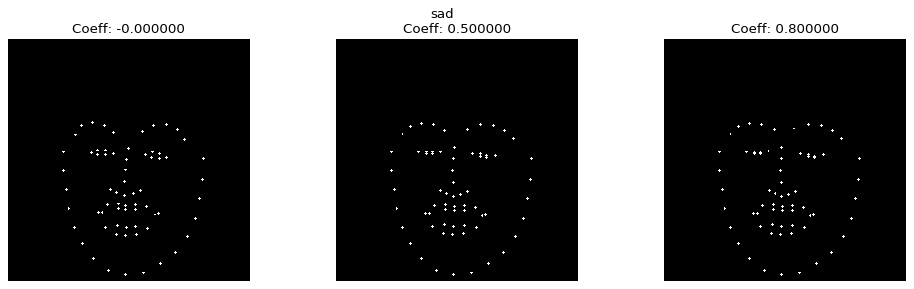

In [95]:
# Gradient ascent

def gradient_ascent(lm, model, coeff=0., n_iters=100, device='cuda'):
    coeff = torch.tensor(coeff, device=device)
    inp = lm.clone()[:, 17:].to(device)
    inp.requires_grad = True
    
    opt = torch.optim.SGD([inp], lr=0.001)
    
    for i in range(n_iters):
        out = torch.sigmoid(model(inp))
        
        loss = F.mse_loss(out, coeff)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
                      
    ret = lm.clone()
    ret[:, 17:] = inp.detach().cpu()
    return ret


def move_and_show_gradient_ascent(lm, model, coeffs, emotion):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 4), dpi=80)
    fig.suptitle(emotion)
    
    model = model.to(device)
    
    for i, coeff in enumerate(coeffs):
        lm = gradient_ascent(lm, inn, coeff=coeff)
        img = display_landmarks(lm[0])
        print(torch.sigmoid(model(lm[:, 17:].to(device))))
        ax[i].imshow(img)
        ax[i].set_title('Coeff: %f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()
    
    
lm = X[6].clone().unsqueeze(0)
move_and_show_gradient_ascent(lm, model, [-0., 0.5, .8], target_emotion)